In [1]:
import os
import json
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import efficientnet_b3
from torchvision.models import convnext_tiny
import torch.nn.functional as F

# % pip install timm
# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F
from torch.autograd import Variable
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip ./drive/MyDrive/소재.zip -d ./zip_data


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./zip_data/pic_filter/359560.jpg  
  inflating: ./zip_data/pic_filter/359570.jpg  
  inflating: ./zip_data/pic_filter/359730.jpg  
  inflating: ./zip_data/pic_filter/359760.jpg  
  inflating: ./zip_data/pic_filter/360201.jpg  
  inflating: ./zip_data/pic_filter/360230.jpg  
  inflating: ./zip_data/pic_filter/360290.jpg  
  inflating: ./zip_data/pic_filter/360440.jpg  
  inflating: ./zip_data/pic_filter/360480.jpg  
  inflating: ./zip_data/pic_filter/360620.jpg  
  inflating: ./zip_data/pic_filter/360670.jpg  
  inflating: ./zip_data/pic_filter/360780.jpg  
  inflating: ./zip_data/pic_filter/360880.jpg  
  inflating: ./zip_data/pic_filter/360901.jpg  
  inflating: ./zip_data/pic_filter/360970.jpg  
  inflating: ./zip_data/pic_filter/360990.jpg  
  inflating: ./zip_data/pic_filter/361020.jpg  
  inflating: ./zip_data/pic_filter/361030.jpg  
  inflating: ./zip_data/pic_filter/361040.jpg  
  inflating: ./zip_data/pic_filter/361080.jpg  
  in

In [4]:
zip_dir = "./zip_data"
save_dir = "./drive/MyDrive/laundry_step_ckpoint"

json_dir = "./zip_data/json_filter"
image_dir = "./zip_data/pic_filter"

json_files = []
image_files = []

for train_file in os.listdir(json_dir):
    json_files.append(os.path.join(json_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
# print("json 장르", json_genre)
# print("image 장르", image_genre)

데이터 개수: 18003
이미지 개수: 18003


In [ ]:
# os.mkdir(f"{save_dir}")

In [5]:
train_image, val_image, train_json, val_json = train_test_split(image_files, json_files, test_size=0.2, random_state=42, shuffle=True)
print(len(train_image), len(val_image))
print(len(train_json), len(val_json))

14402 3601
14402 3601


In [6]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric

        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        
# train_image_dict.items()
# valid_image_dict

100%|██████████| 3601/3601 [00:00<00:00, 7506.05it/s]


In [7]:
#사용자 정의 데이터셋
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, transform=None, data_dir=r"./zip_data/pic_filter"): 
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.transform = transform
        self.image_files = []
        self.dict_label_to_num = {
            "메시": 0,"데님" : 0 , "우븐": 0 ,"패딩" : 0,
            "니트":1,"레이스":1,"린넨":1,"플리스":1,"네오프렌":1, "저지":1,"울/캐시미어" :1,"헤어 니트": 1,
            "퍼":2,"코듀로이":2,"실크":2,"스판덱스":2,"트위드":2,"자카드":2 ,"벨벳":2,"시폰":2,
            "스웨이드":3,"시퀸/글리터":3,"가죽":3,"비닐/PVC":3
          
        } #0:물세탁, 1:울세탁, 2:드라이클리닝, 3:기타
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        # im = transforms.Normalize((0.4,),(0.4,))(im) #######
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((224,224))(im) #,Image.BILINEAR
        # transform = transforms.RandomHorizontalFlip(p=1)
        # imgs = transform(im)
        
        # torchvision_transform=transforms.Compose([
        #                                 transforms.RandomHorizontalFlip(),
        #                                 transforms.ToTensor(),
        #                                 transforms.Normalize((0.1307,),(0.3081,))])
        # im = torchvision_transform(im)
        fabric_label = self.dict_label_to_num[fabric]
  
        
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)

torchvision_transform=transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])
torchvision_dataset = ClothDataset(train_image_dict,transform=torchvision_transform)

In [ ]:
# class ClothDataset(Dataset):
#     def __init__(self, train_image_dict, data_dir=r"./zip_data/pic_filter"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
#         super().__init__()
#         self.data_dir = data_dir
#         self.train_image_dict = train_image_dict
#         self.image_files = []
#         self.dict_label_to_num = {
#             "퍼" : 0,
#             "니트" : 1,
            
#             "레이스" : 2,
#             "스웨이드" : 3,
#             "린넨" : 4,
            
#             "메시" : 5,
#             "코듀로이" : 6,
#             "플리스" : 7,
#             "시퀸/글리터" : 8,
#             "네오프렌" : 9,
#             "데님" : 10,
#             "실크" : 11,
#             "저지" : 12,
#             "스판덱스" : 13,
#             "트위드" : 14,
#             "자카드" : 15,
#             "벨벳" : 16,
#             "가죽" : 17,
#             "비닐/PVC" : 18,
            
#             "울/캐시미어" : 19,
#             "시폰" : 20,
            
#             "우븐" : 21,
#             "패딩" : 22,
#             "헤어 니트": 23
#         }
#         self.setup()

#     def setup(self):
#         for (file_name, xy), fabric in self.train_image_dict.items():
#             if not fabric:
#                 continue
#             self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric)) #os.path.join(data_dir+이미지명)/좌표/직물을 list에

#     def __getitem__(self, idx):
#         file_name, xy, fabric = self.image_files[idx]
#         fabric=fabric[0]
#         x, y, w, h = map(int, xy)
# #         
#         im = Image.open(file_name)
#         im = transforms.ToTensor()(im)
#         im = torchvision.transforms.functional.crop(im, y, x, h, w)
#         im = transforms.Resize((150,150))(im)

#         fabric_label = self.dict_label_to_num[fabric]
#         return im, fabric_label
    
#     def __len__(self):
#         return len(self.image_files)



In [8]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
print(train_dataset[0]) #[0]
# print(len(torchvision_dataset))
print(len(train_dataset))
print(len(valid_dataset))

(tensor([[[0.7793, 0.7725, 0.7804,  ..., 0.7036, 0.6758, 0.6748],
         [0.7754, 0.7694, 0.7673,  ..., 0.7552, 0.7100, 0.7622],
         [0.7818, 0.7779, 0.7721,  ..., 0.6940, 0.6682, 0.6270],
         ...,
         [0.7127, 0.7137, 0.7137,  ..., 0.0184, 0.0118, 0.0118],
         [0.7127, 0.7137, 0.7137,  ..., 0.0263, 0.0196, 0.0196],
         [0.7176, 0.7176, 0.7176,  ..., 0.0322, 0.0125, 0.0128]],

        [[0.7401, 0.7333, 0.7412,  ..., 0.6158, 0.5974, 0.5924],
         [0.7362, 0.7302, 0.7281,  ..., 0.6674, 0.6316, 0.6798],
         [0.7426, 0.7387, 0.7328,  ..., 0.6063, 0.5898, 0.5446],
         ...,
         [0.6421, 0.6431, 0.6431,  ..., 0.0184, 0.0118, 0.0118],
         [0.6421, 0.6431, 0.6431,  ..., 0.0263, 0.0196, 0.0196],
         [0.6471, 0.6471, 0.6471,  ..., 0.0322, 0.0125, 0.0128]],

        [[0.7048, 0.6980, 0.7059,  ..., 0.5111, 0.4915, 0.4787],
         [0.7009, 0.6949, 0.6928,  ..., 0.5627, 0.5257, 0.5661],
         [0.7073, 0.7034, 0.6975,  ..., 0.5016, 0.4839, 0

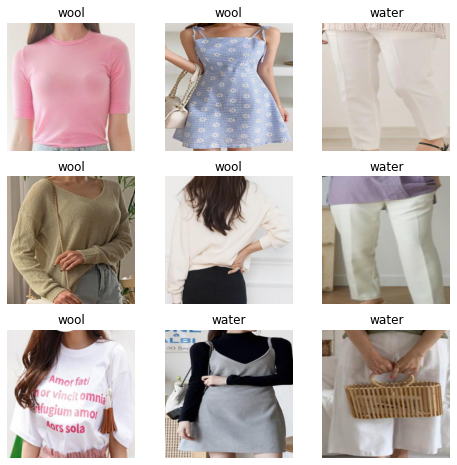

In [ ]:
classes=["water",
        "wool",
        "dry cleaning",
        "etc"] 

# y=train_dataset[18][1] #dict의 18번째 label-->label 값을 뜻한다
figure = plt.figure(figsize=(8,8))
cols, rows= 3,3

for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_dataset),size=(1,)).item()
    
    # img, label= train_dataset[sample_idx]
    img, label= torchvision_dataset[sample_idx]

    figure.add_subplot(rows, cols, i)
    title=classes[label]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

14113


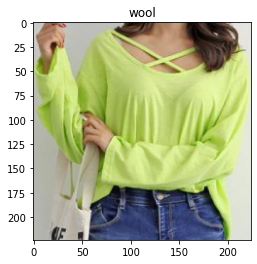

In [ ]:
idx = np.random.randint(0, len(train_dataset))
print(idx)
title=classes[train_dataset[idx][1]]
plt.title(title)
plt.imshow(train_dataset[idx][0].permute(1,2,0))

In [9]:
class efficientnet_b3(nn.Module): #Resnet50
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b3(pretrained=True) #50
        

        self.fc = nn.Linear(1000, num_classes) #1000
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [ ]:
# class Resnet50(nn.Module): #Resnet50
#     def __init__(self, num_classes):
#         super().__init__()
#         self.model = torchvision.models.resnet50(pretrained=True) #50
        

#         self.fc = nn.Linear(1000, num_classes) #1000
#         # self.dropout=nn.Dropout(0.25) #############
#     def forward(self, x):
#         x = self.model(x)
#         return self.fc(x)


In [ ]:
# class vit_base_patch16_224(nn.Module): #Resnet50
#     def __init__(self, num_classes):
#         super().__init__()
#         self.model = timm.models.vit_base_patch16_224(pretrained=True) #50
        

#         self.fc = nn.Linear(1000, num_classes) #1000
#         # self.dropout=nn.Dropout(0.25) #############
#     def forward(self, x):
#         x = self.model(x)
#         return self.fc(x)

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #,long
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
BATCH_SIZE =64 #32 작은 것보다 오히려 큰게 나을수도
EPOCHS =10
LOG_INTERVAL=34 #35
LEARNING_RATE=0.001 #0.001

torch.cuda.empty_cache()
device=torch.device("cuda") # if torch.cuda.is_available() else "cpu"

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

# model = timm.create_model("vit_base_patch16_224",pretrained=True,num_classes=4).cuda()
# config=resolve_data_config({}, model=model)
# transform = create_transform(**config)

# model = vit_base_patch16_224(num_classes=4).cuda()
model = efficientnet_b3(num_classes=4).cuda() #gpu
# model = Resnet50(num_classes=4).cuda() #gpu

# criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.9) #1e-5
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5) #0.5
best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)    
        num_label=labels.tolist()     #😊
        num_pred=preds.tolist() 
        # total_label.extend(num_label)
        # total_pred.extend(num_pred)      

        loss = FocalLoss(gamma=2)(outs,labels)
        
        # loss = criterion(outs, labels)
        # loss = loss+l2_lambda*l2_norm

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            torch.save(model.state_dict(), f"{save_dir}/{idx}.pth")
            loss_value = 0
            matches = 0
    scheduler.step()
    

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() #검증 모드,검증 목적은 최적의 epoch를 찾아 overfiting과 unseen data 문제 를 막는 것
        val_loss_items=[]
        val_acc_items=[]
        total_label=[]
        total_pred=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            num_label=labels.tolist()     #😊
            num_pred=preds.tolist() 
            total_label.extend(num_label)
            total_pred.extend(num_pred)


            loss_item = FocalLoss(gamma=2)(outs,labels).item()
            # loss_item = criterion(outs, labels).item()            
            acc_item = (labels == preds).sum().item()
            
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)
        print('label:', total_label)
        print('pred:', total_pred)
        print(classification_report(total_label, total_pred, target_names=['class 0', 'class 1', 'class 2','class 3']))

        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            torch.save(model.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        
        torch.save(model.state_dict(),f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

  9%|▉         | 33/350 [00:47<07:37,  1.44s/it]

Epoch[0/10](34/350) || training loss 0.6528 || training accuracy 50.69%


 19%|█▉        | 67/350 [01:37<06:50,  1.45s/it]

Epoch[0/10](68/350) || training loss 0.4173 || training accuracy 61.81%


 29%|██▉       | 101/350 [02:26<05:55,  1.43s/it]

Epoch[0/10](102/350) || training loss 0.4129 || training accuracy 61.95%


 39%|███▊      | 135/350 [03:16<05:14,  1.46s/it]

Epoch[0/10](136/350) || training loss 0.3998 || training accuracy 61.90%


 48%|████▊     | 169/350 [04:05<04:19,  1.43s/it]

Epoch[0/10](170/350) || training loss 0.3764 || training accuracy 65.85%


 58%|█████▊    | 203/350 [04:55<03:31,  1.44s/it]

Epoch[0/10](204/350) || training loss 0.3677 || training accuracy 64.66%


 68%|██████▊   | 237/350 [05:44<02:42,  1.44s/it]

Epoch[0/10](238/350) || training loss 0.3732 || training accuracy 63.60%


 77%|███████▋  | 271/350 [06:33<01:53,  1.43s/it]

Epoch[0/10](272/350) || training loss 0.364 || training accuracy 66.64%


 87%|████████▋ | 305/350 [07:22<01:04,  1.43s/it]

Epoch[0/10](306/350) || training loss 0.3572 || training accuracy 66.87%


 97%|█████████▋| 339/350 [08:11<00:16,  1.46s/it]

Epoch[0/10](340/350) || training loss 0.3443 || training accuracy 69.16%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


label: [0, 0, 0, 0, 1, 3, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 0, 3, 2, 3, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 3, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 3, 0, 2, 2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 2, 3, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1,

  9%|▉         | 33/350 [00:47<07:40,  1.45s/it]

Epoch[1/10](34/350) || training loss 0.299 || training accuracy 72.43%


 19%|█▉        | 67/350 [01:37<06:45,  1.43s/it]

Epoch[1/10](68/350) || training loss 0.2949 || training accuracy 71.42%


 29%|██▉       | 101/350 [02:26<05:54,  1.42s/it]

Epoch[1/10](102/350) || training loss 0.2678 || training accuracy 74.36%


 39%|███▊      | 135/350 [03:15<05:09,  1.44s/it]

Epoch[1/10](136/350) || training loss 0.265 || training accuracy 74.49%


 48%|████▊     | 169/350 [04:05<04:22,  1.45s/it]

Epoch[1/10](170/350) || training loss 0.2873 || training accuracy 70.73%


 58%|█████▊    | 203/350 [04:54<03:34,  1.46s/it]

Epoch[1/10](204/350) || training loss 0.2868 || training accuracy 71.09%


 68%|██████▊   | 237/350 [05:44<02:44,  1.45s/it]

Epoch[1/10](238/350) || training loss 0.2777 || training accuracy 71.88%


 77%|███████▋  | 271/350 [06:33<01:53,  1.44s/it]

Epoch[1/10](272/350) || training loss 0.297 || training accuracy 73.25%


 87%|████████▋ | 305/350 [07:23<01:04,  1.43s/it]

Epoch[1/10](306/350) || training loss 0.3009 || training accuracy 71.37%


 97%|█████████▋| 339/350 [08:12<00:15,  1.43s/it]

Epoch[1/10](340/350) || training loss 0.291 || training accuracy 71.97%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.09s/it]


label: [2, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 3, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 1, 1, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1, 2,

  9%|▉         | 33/350 [00:47<07:30,  1.42s/it]

Epoch[2/10](34/350) || training loss 0.2115 || training accuracy 78.40%


 19%|█▉        | 67/350 [01:36<06:45,  1.43s/it]

Epoch[2/10](68/350) || training loss 0.2055 || training accuracy 77.48%


 29%|██▉       | 101/350 [02:26<06:02,  1.46s/it]

Epoch[2/10](102/350) || training loss 0.1967 || training accuracy 79.04%


 39%|███▊      | 135/350 [03:16<05:14,  1.46s/it]

Epoch[2/10](136/350) || training loss 0.204 || training accuracy 78.49%


 48%|████▊     | 169/350 [04:06<04:20,  1.44s/it]

Epoch[2/10](170/350) || training loss 0.2052 || training accuracy 78.54%


 58%|█████▊    | 203/350 [04:55<03:31,  1.44s/it]

Epoch[2/10](204/350) || training loss 0.2119 || training accuracy 78.58%


 68%|██████▊   | 237/350 [05:44<02:42,  1.43s/it]

Epoch[2/10](238/350) || training loss 0.2094 || training accuracy 77.21%


 77%|███████▋  | 271/350 [06:33<01:53,  1.43s/it]

Epoch[2/10](272/350) || training loss 0.229 || training accuracy 75.92%


 87%|████████▋ | 305/350 [07:22<01:05,  1.46s/it]

Epoch[2/10](306/350) || training loss 0.2165 || training accuracy 77.80%


 97%|█████████▋| 339/350 [08:12<00:15,  1.45s/it]

Epoch[2/10](340/350) || training loss 0.2072 || training accuracy 77.62%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


label: [1, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 3, 1, 1, 1, 2, 1, 0, 1, 1, 0, 3, 3, 1, 1, 0, 2, 2, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 3, 0, 1, 0, 2, 1, 1, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 3, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 3, 2,

  9%|▉         | 33/350 [00:47<07:42,  1.46s/it]

Epoch[3/10](34/350) || training loss 0.1682 || training accuracy 80.56%


 19%|█▉        | 67/350 [01:37<06:43,  1.43s/it]

Epoch[3/10](68/350) || training loss 0.1503 || training accuracy 82.81%


 29%|██▉       | 101/350 [02:26<06:00,  1.45s/it]

Epoch[3/10](102/350) || training loss 0.1465 || training accuracy 82.31%


 39%|███▊      | 135/350 [03:15<05:07,  1.43s/it]

Epoch[3/10](136/350) || training loss 0.1269 || training accuracy 84.01%


 48%|████▊     | 169/350 [04:04<04:22,  1.45s/it]

Epoch[3/10](170/350) || training loss 0.1273 || training accuracy 85.39%


 58%|█████▊    | 203/350 [04:54<03:33,  1.46s/it]

Epoch[3/10](204/350) || training loss 0.132 || training accuracy 84.65%


 68%|██████▊   | 237/350 [05:44<02:46,  1.47s/it]

Epoch[3/10](238/350) || training loss 0.1381 || training accuracy 84.56%


 77%|███████▋  | 271/350 [06:33<01:53,  1.44s/it]

Epoch[3/10](272/350) || training loss 0.124 || training accuracy 85.75%


 87%|████████▋ | 305/350 [07:22<01:04,  1.44s/it]

Epoch[3/10](306/350) || training loss 0.124 || training accuracy 85.80%


 97%|█████████▋| 339/350 [08:12<00:15,  1.45s/it]

Epoch[3/10](340/350) || training loss 0.1324 || training accuracy 85.25%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.09s/it]


label: [0, 1, 0, 1, 2, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 3, 2, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 3, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1, 3, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,

  9%|▉         | 33/350 [00:47<07:31,  1.43s/it]

Epoch[4/10](34/350) || training loss 0.08931 || training accuracy 89.89%


 19%|█▉        | 67/350 [01:37<06:55,  1.47s/it]

Epoch[4/10](68/350) || training loss 0.08002 || training accuracy 90.44%


 29%|██▉       | 101/350 [02:26<06:03,  1.46s/it]

Epoch[4/10](102/350) || training loss 0.0781 || training accuracy 89.89%


 39%|███▊      | 135/350 [03:16<05:12,  1.46s/it]

Epoch[4/10](136/350) || training loss 0.07999 || training accuracy 89.25%


 48%|████▊     | 169/350 [04:05<04:24,  1.46s/it]

Epoch[4/10](170/350) || training loss 0.07523 || training accuracy 89.61%


 58%|█████▊    | 203/350 [04:54<03:29,  1.42s/it]

Epoch[4/10](204/350) || training loss 0.06923 || training accuracy 90.95%


 68%|██████▊   | 237/350 [05:43<02:42,  1.44s/it]

Epoch[4/10](238/350) || training loss 0.06952 || training accuracy 90.44%


 77%|███████▋  | 271/350 [06:33<01:53,  1.44s/it]

Epoch[4/10](272/350) || training loss 0.0705 || training accuracy 89.98%


 87%|████████▋ | 305/350 [07:22<01:05,  1.46s/it]

Epoch[4/10](306/350) || training loss 0.06894 || training accuracy 91.36%


 97%|█████████▋| 339/350 [08:12<00:15,  1.45s/it]

Epoch[4/10](340/350) || training loss 0.07959 || training accuracy 89.71%


100%|██████████| 350/350 [08:27<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


label: [1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 3, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 2, 3, 1, 1, 1, 1, 2,

  9%|▉         | 33/350 [00:47<07:37,  1.44s/it]

Epoch[5/10](34/350) || training loss 0.05643 || training accuracy 93.06%


 19%|█▉        | 67/350 [01:36<06:47,  1.44s/it]

Epoch[5/10](68/350) || training loss 0.05369 || training accuracy 93.70%


 29%|██▉       | 101/350 [02:26<05:58,  1.44s/it]

Epoch[5/10](102/350) || training loss 0.04828 || training accuracy 94.16%


 39%|███▊      | 135/350 [03:15<05:08,  1.44s/it]

Epoch[5/10](136/350) || training loss 0.04961 || training accuracy 93.38%


 48%|████▊     | 169/350 [04:04<04:19,  1.43s/it]

Epoch[5/10](170/350) || training loss 0.05358 || training accuracy 93.70%


 58%|█████▊    | 203/350 [04:53<03:32,  1.44s/it]

Epoch[5/10](204/350) || training loss 0.04953 || training accuracy 93.80%


 68%|██████▊   | 237/350 [05:42<02:41,  1.43s/it]

Epoch[5/10](238/350) || training loss 0.04913 || training accuracy 93.57%


 77%|███████▋  | 271/350 [06:32<01:54,  1.45s/it]

Epoch[5/10](272/350) || training loss 0.04994 || training accuracy 92.83%


 87%|████████▋ | 305/350 [07:21<01:04,  1.44s/it]

Epoch[5/10](306/350) || training loss 0.04699 || training accuracy 93.75%


 97%|█████████▋| 339/350 [08:11<00:15,  1.43s/it]

Epoch[5/10](340/350) || training loss 0.05333 || training accuracy 92.78%


100%|██████████| 350/350 [08:27<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


label: [1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 2, 2, 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 3, 1, 0, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0,

  9%|▉         | 33/350 [00:47<07:34,  1.44s/it]

Epoch[6/10](34/350) || training loss 0.03707 || training accuracy 95.73%


 19%|█▉        | 67/350 [01:36<06:50,  1.45s/it]

Epoch[6/10](68/350) || training loss 0.03821 || training accuracy 95.08%


 29%|██▉       | 101/350 [02:26<05:58,  1.44s/it]

Epoch[6/10](102/350) || training loss 0.03739 || training accuracy 95.22%


 39%|███▊      | 135/350 [03:16<05:12,  1.46s/it]

Epoch[6/10](136/350) || training loss 0.03312 || training accuracy 96.19%


 48%|████▊     | 169/350 [04:05<04:22,  1.45s/it]

Epoch[6/10](170/350) || training loss 0.0332 || training accuracy 96.32%


 58%|█████▊    | 203/350 [04:55<03:33,  1.45s/it]

Epoch[6/10](204/350) || training loss 0.03909 || training accuracy 95.13%


 68%|██████▊   | 237/350 [05:44<02:44,  1.45s/it]

Epoch[6/10](238/350) || training loss 0.03696 || training accuracy 96.05%


 77%|███████▋  | 271/350 [06:33<01:54,  1.44s/it]

Epoch[6/10](272/350) || training loss 0.03647 || training accuracy 94.90%


 87%|████████▋ | 305/350 [07:23<01:04,  1.44s/it]

Epoch[6/10](306/350) || training loss 0.04411 || training accuracy 94.30%


 97%|█████████▋| 339/350 [08:12<00:15,  1.44s/it]

Epoch[6/10](340/350) || training loss 0.03367 || training accuracy 95.63%


100%|██████████| 350/350 [08:29<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


label: [1, 2, 1, 1, 2, 0, 2, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 3, 2, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 2, 0, 2, 0, 1,

  9%|▉         | 33/350 [00:47<07:36,  1.44s/it]

Epoch[7/10](34/350) || training loss 0.03113 || training accuracy 96.23%


 19%|█▉        | 67/350 [01:37<06:46,  1.44s/it]

Epoch[7/10](68/350) || training loss 0.03459 || training accuracy 96.42%


 29%|██▉       | 101/350 [02:26<05:55,  1.43s/it]

Epoch[7/10](102/350) || training loss 0.03561 || training accuracy 94.81%


 39%|███▊      | 135/350 [03:15<05:10,  1.45s/it]

Epoch[7/10](136/350) || training loss 0.03633 || training accuracy 96.00%


 48%|████▊     | 169/350 [04:05<04:19,  1.43s/it]

Epoch[7/10](170/350) || training loss 0.03071 || training accuracy 96.32%


 58%|█████▊    | 203/350 [04:54<03:31,  1.44s/it]

Epoch[7/10](204/350) || training loss 0.02913 || training accuracy 96.28%


 68%|██████▊   | 237/350 [05:43<02:45,  1.46s/it]

Epoch[7/10](238/350) || training loss 0.03082 || training accuracy 96.00%


 77%|███████▋  | 271/350 [06:32<01:54,  1.45s/it]

Epoch[7/10](272/350) || training loss 0.03528 || training accuracy 95.54%


 87%|████████▋ | 305/350 [07:22<01:06,  1.48s/it]

Epoch[7/10](306/350) || training loss 0.03097 || training accuracy 96.42%


 97%|█████████▋| 339/350 [08:12<00:16,  1.47s/it]

Epoch[7/10](340/350) || training loss 0.03332 || training accuracy 95.96%


100%|██████████| 350/350 [08:29<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:36<00:00,  1.11s/it]


label: [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 1, 2, 0, 3, 0, 1, 1, 0, 2, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 2,

  9%|▉         | 33/350 [00:47<07:35,  1.44s/it]

Epoch[8/10](34/350) || training loss 0.02928 || training accuracy 96.46%


 19%|█▉        | 67/350 [01:37<06:57,  1.47s/it]

Epoch[8/10](68/350) || training loss 0.02717 || training accuracy 96.46%


 29%|██▉       | 101/350 [02:26<06:09,  1.49s/it]

Epoch[8/10](102/350) || training loss 0.02974 || training accuracy 96.28%


 39%|███▊      | 135/350 [03:16<05:12,  1.45s/it]

Epoch[8/10](136/350) || training loss 0.03076 || training accuracy 96.32%


 48%|████▊     | 169/350 [04:06<04:21,  1.44s/it]

Epoch[8/10](170/350) || training loss 0.0332 || training accuracy 95.54%


 58%|█████▊    | 203/350 [04:55<03:31,  1.44s/it]

Epoch[8/10](204/350) || training loss 0.03005 || training accuracy 96.05%


 68%|██████▊   | 237/350 [05:44<02:43,  1.45s/it]

Epoch[8/10](238/350) || training loss 0.02956 || training accuracy 96.65%


 77%|███████▋  | 271/350 [06:33<01:53,  1.44s/it]

Epoch[8/10](272/350) || training loss 0.03121 || training accuracy 95.73%


 87%|████████▋ | 305/350 [07:23<01:04,  1.43s/it]

Epoch[8/10](306/350) || training loss 0.03009 || training accuracy 96.28%


 97%|█████████▋| 339/350 [08:12<00:15,  1.44s/it]

Epoch[8/10](340/350) || training loss 0.02894 || training accuracy 96.00%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


label: [2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 3, 0, 1, 0, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2, 1, 3, 2, 1, 0, 2, 2, 1, 3, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 2, 3, 1, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 0, 2, 2, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0,

  9%|▉         | 33/350 [00:47<07:40,  1.45s/it]

Epoch[9/10](34/350) || training loss 0.02734 || training accuracy 96.51%


 19%|█▉        | 67/350 [01:37<06:51,  1.45s/it]

Epoch[9/10](68/350) || training loss 0.02582 || training accuracy 96.78%


 29%|██▉       | 101/350 [02:27<06:00,  1.45s/it]

Epoch[9/10](102/350) || training loss 0.03038 || training accuracy 96.05%


 39%|███▊      | 135/350 [03:16<05:10,  1.44s/it]

Epoch[9/10](136/350) || training loss 0.02653 || training accuracy 96.74%


 48%|████▊     | 169/350 [04:05<04:18,  1.43s/it]

Epoch[9/10](170/350) || training loss 0.03065 || training accuracy 95.96%


 58%|█████▊    | 203/350 [04:55<03:30,  1.43s/it]

Epoch[9/10](204/350) || training loss 0.02578 || training accuracy 97.01%


 68%|██████▊   | 237/350 [05:44<02:41,  1.42s/it]

Epoch[9/10](238/350) || training loss 0.03038 || training accuracy 96.19%


 77%|███████▋  | 271/350 [06:33<01:54,  1.45s/it]

Epoch[9/10](272/350) || training loss 0.02867 || training accuracy 96.42%


 87%|████████▋ | 305/350 [07:22<01:05,  1.45s/it]

Epoch[9/10](306/350) || training loss 0.02599 || training accuracy 96.97%


 97%|█████████▋| 339/350 [08:11<00:15,  1.43s/it]

Epoch[9/10](340/350) || training loss 0.02404 || training accuracy 97.15%


100%|██████████| 350/350 [08:28<00:00,  1.45s/it]


Calculating validation results...


100%|██████████| 87/87 [01:34<00:00,  1.09s/it]


label: [1, 2, 1, 1, 0, 0, 0, 3, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 0, 3, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2,

In [11]:
model = efficientnet_b3(num_classes=4)
model.eval()
model.load_state_dict(torch.load(f"{save_dir}/best.pth"))



Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

<All keys matched successfully>

In [12]:
img=Image.open('./drive/MyDrive/(9)IMG_1.jpg')
image=np.array(cv2.imread('./drive/MyDrive/(9)IMG_1.jpg'))
image=cv2.resize(image,(150,150), interpolation=cv2.INTER_LINEAR)
# image_swap=np.swapaxes(img,0,2)
# print(image_swap)
# im=transforms.ToTensor()(img)
image_swap=np.swapaxes(image, 0,2)
image_swap=np.expand_dims(image_swap,axis=0)
print(image_swap)
image_swap.shape
tensor=torch.from_numpy(image_swap).type(torch.FloatTensor)

out=model(tensor)
pred=torch.argmax(out,dim=-1)
print(pred)



[[[[245 244 246 ... 199 175 144]
   [244 245 248 ... 181 193 175]
   [244 247 247 ... 156 143 170]
   ...
   [182 185 185 ... 106 147 132]
   [182 184 185 ... 148 192 138]
   [183 183 185 ... 108 153 182]]

  [[222 221 222 ... 228 204 173]
   [221 222 225 ... 210 222 204]
   [221 224 224 ... 185 172 199]
   ...
   [128 131 131 ... 134 175 160]
   [128 130 131 ... 177 220 166]
   [129 129 131 ... 136 181 210]]

  [[206 205 206 ... 242 218 187]
   [205 206 209 ... 225 237 218]
   [205 208 208 ... 200 187 213]
   ...
   [ 81  84  84 ... 145 186 171]
   [ 81  83  84 ... 188 231 177]
   [ 82  82  84 ... 147 192 221]]]]
tensor([0])


In [ ]:
model(tensor)

tensor([[ 1.3100,  1.1580, -0.5965, -3.5507]], grad_fn=<AddmmBackward0>)

In [13]:
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# %pip install -qr requirements.txt # install dependencies
# %pip install -q roboflow

Cloning into 'yolov5'...
remote: Enumerating objects: 13329, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 13329 (delta 30), reused 39 (delta 29), pack-reused 13286
Receiving objects: 100% (13329/13329), 12.05 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (9280/9280), done.
/content/yolov5
     |████████████████████████████████| 596 kB 13.8 MB/s 
     |████████████████████████████████| 145 kB 15.9 MB/s 
     |████████████████████████████████| 178 kB 83.8 MB/s 
     |████████████████████████████████| 1.1 MB 80.3 MB/s 
     |████████████████████████████████| 67 kB 7.7 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 138 kB 98.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googl

In [22]:
!python detect.py --weight ./drive/MyDrive/best.pt --source ./drive/MyDrive/(9)IMG_1.jpg

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `python detect.py --weight best.pt --source ./drive/MyDrive/(9)IMG_1.jpg'


In [19]:
# # img=Image.open('./drive/MyDrive/(9)IMG_1.jpg')

# img=image.open(r"C:\Users\dra04\fashion_image\yolov5\runs\detect\exp7\(9)IMG_1.jpg")
# plt.imshow(img.permute(1,2,0))


AttributeError: ignored

In [ ]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
model.eval() #Need to put the model in evaluation mode

In [ ]:
# from PIL import Image
# import numpy as np
# from io import BytesIO
# import requests
# from torchvision import transforms as T
# import matplotlib.pyplot as plt
# import cv2
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [ ]:
# COCO_INSTANCE_CATEGORY_NAMES=[ '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
#     'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
#     'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
#     'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
#     'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#     'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
#     'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
#     'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#     'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
#     'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
#     'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
#     'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] #'__backgournd__',
# def get_prediction(img, threshold=0.5):
#     transform=transforms.Compose([transforms.ToTensor()])
#     img=transform(img)
#     pred=model([img])
#     pred_class=[COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
#     pred_boxes=[[(i[0],i[1]),(i[2],i[3])] for i in list(pred[0]['boxes'].detach())]
#     pred_score=list(pred[0]['scores'].detach().numpy())
#     pred_t=[pred_score.index(x) for x in pred_score if x>threshold][1]
#     pred_box=pred_boxes[:pred_t+1]
#     pred_class=pred_class[:pred_t+1]
#     return pred_box, pred_class

In [ ]:
# from urllib.request import urlopen
# def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
#     resp=urlopen(url)
#     image=np.asarray(bytearray(resp.read()),dtype='uint8')
#     image=cv2.imdecode(image, readFlag)
#     return image

In [ ]:
# import random
# def object_detection(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3,url=False):
#     if url:
#         img=url_to_image(img_path)
#     else:
#         img=cv2.imread(img_path)
#     boxes, pred_clas=get_prediction(img, threshold=0.5)
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     for i in range(len(boxes)):
#         r,g,b=(random.randint(0,255),random.randint(0,255),random.randint(0,255))
#         cv2.rectangle(img, boxes[i][0],boxes[i][1], color=(r,g,b), thickness=rect_th)
#         cv2.putText(img, pred_clas[i],boxes[i][0],cv2.FONT_HERSHEY_SIMPLEX,text_size,(r,g,b),thickness=text_th)
#     plt.figure(figsize=(15,15))
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
        

In [ ]:
# threshold=0.5
# img=Image.open('./drive/MyDrive/(9)IMG_1.jpg')
# transform=transforms.Compose([transforms.ToTensor()])
# img=transform(img)
# pred=model([img])
# print(pred[0]['labels'].numpy())
# pred_class=[COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
# pred_boxes=[[(i[0],i[1]),(i[2],i[3])] for i in list(pred[0]['boxes'].detach())]
# pred_score=list(pred[0]['scores'].detach().numpy())
# pred_t=[pred_score.index(x) for x in pred_score if x>threshold][1]
# pred_box=pred_boxes[:pred_t+1]
# pred_class=pred_class[:pred_t+1]

object_detection('./drive/MyDrive/(9)IMG_1.jpg', rect_th=3, text_size=3, text_th=3)

# transform=transforms.Compose([transforms.ToTensor()])
# img=transform(img)

In [ ]:
a=[1,2,3,0,1,1,2,1]
b=[3,1,2,0,1,0]
c=[]
c.extend(a)
c.extend(b)
print(c[:5])
